# analysis of model performance on in-domain-data

In [ ]:
model_path = "### add_the_model_path_ which_you_want_to_analyse ##"

In [2]:
import abc

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models
from torchvision.models import ResNet34_Weights
from legacy.zoo.models import *
from datasets.base_dataset import LabeledDataset
from torch.utils.data import DataLoader


In [3]:

model = Res34_Unet_Double(pretrained = False)
checkpoint = torch.load(model_path)
#our model keys and saved checkpoint keys are mismatched, so we need to correct them
new_state_dict = {}
for key,value in checkpoint['state_dict'].items():
    new_key = key.replace('model.','')
    new_state_dict[new_key]=value
model.load_state_dict(new_state_dict)
missing_keys, unexpected_keys = model.load_state_dict(new_state_dict,strict=False)
print(f'missing_keys = {missing_keys}')
print(f'unexpected_keys = {unexpected_keys}')



missing_keys = []
unexpected_keys = []


In [4]:
model

Res34_Unet_Double(
  (conv6): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(512, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv6_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(576, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv7): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(320, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv7_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(288, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv8): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(160, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv8_2): ConvRelu(
    (layer): Sequential(
      (0): Conv2d(160, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=Tru

# function to process datafile

In [5]:
import cv2
import numpy as np
import torch
import os
from typing import Dict, Union, Any, List

def normalize_image(img: torch.Tensor) -> torch.Tensor:
    img = img.to(torch.float32)
    img /= 127
    img -= 1
    return img


def process_images(images_folder: str, masks_folder: str) -> List[Dict[str, Union[torch.Tensor, Any]]]:
    results = []

    for image_filename in os.listdir(images_folder):
        if '_pre_' not in image_filename:
            continue

        # Construct full paths for pre-disaster and post-disaster images
        img_pre_path = os.path.join(images_folder, image_filename)
        img_post_path = img_pre_path.replace('_pre_', '_post_')

        # Construct full paths for pre-disaster and post-disaster masks
        msk_pre_path = os.path.join(masks_folder, image_filename)
        msk_post_path = msk_pre_path.replace('_pre_disaster', '_post_disaster')

        # Print paths for debugging
        # print(f"Processing image: {image_filename}")
        # print(f"img_pre_path: {img_pre_path}")
        # print(f"img_post_path: {img_post_path}")
        # print(f"msk_pre_path: {msk_pre_path}")
        # print(f"msk_post_path: {msk_post_path}")

        # Read images
        img_pre = cv2.imread(img_pre_path, cv2.IMREAD_COLOR)
        img_post = cv2.imread(img_post_path, cv2.IMREAD_COLOR)

        # Read masks
        msk_pre = cv2.imread(msk_pre_path, cv2.IMREAD_UNCHANGED)
        msk_post = cv2.imread(msk_post_path, cv2.IMREAD_UNCHANGED)

        if img_pre is None or img_post is None or msk_pre is None or msk_post is None:
            print(f"Skipping file: {image_filename}, missing images or masks.")
            continue

        # Ensure masks are integer type
        msk_pre = msk_pre.astype(np.uint8)
        msk_post = msk_post.astype(np.uint8)

        # Print unique values in masks
        # print(f"Unique values in msk_pre: {np.unique(msk_pre)}")
        # print(f"Unique values in msk_post: {np.unique(msk_post)}")

        # Create separate masks for different disaster levels
        msk0 = (msk_pre > 0).astype(np.uint8)[..., np.newaxis]
        msk1 = (msk_post == 1).astype(np.uint8)[..., np.newaxis]
        msk2 = (msk_post == 2).astype(np.uint8)[..., np.newaxis]
        msk3 = (msk_post == 3).astype(np.uint8)[..., np.newaxis]
        msk4 = (msk_post == 4).astype(np.uint8)[..., np.newaxis]

        # Combine masks
        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)

        # Concatenate pre and post-disaster images
        img = np.concatenate([img_pre, img_post], axis=2)

        # Convert to tensors
        img_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float()
        msk_tensor = torch.from_numpy(msk.transpose((2, 0, 1))).float()

        # Normalize the image tensor
        img_tensor = normalize_image(img_tensor)

        # Add the processed image and mask tensors to the result list
        results.append({'img': img_tensor, 'msk': msk_tensor,'fn':image_filename})

    return results


In [6]:
def create_dataset(dataset,batch_size=8, shuffle=False, num_workers=6):
    dataloader = DataLoader(
        dataset=dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers
    )
    return dataloader

In [7]:
import torch
import torchmetrics
import torchmetrics.classification
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, threshold=0.38, device='cuda'):
    """
    Evaluate the model on the test dataloader and display confusion matrices.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): Dataloader for the test dataset.
        threshold (float): Threshold for the location mask.
        device (str): Device to use for evaluation ('cpu' or 'cuda').

    Returns:
        dict: A dictionary of F1 scores per channel and displays confusion matrices.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    num_classes = 2  # Assuming binary classification
    test_metrics = [torchmetrics.F1Score(num_classes=num_classes, task='binary', average='none').to(device) for _ in range(5)]  # Assuming 5 channels
    #confusion_matrices = [torchmetrics.ConfusionMatrix(num_classes=num_classes,task='multiclass').to(device) for _ in range(5)]  # Confusion matrices for 5 channels
    # Reset metrics
    for metric in test_metrics :
        metric.reset()
    results = {}

    with torch.no_grad():  # No need for gradient computation during evaluation
        for batch_idx, batch in enumerate(test_loader):
            x, y = batch["img"].float().to(device), batch["msk"].float().to(device)
            y_hat = model(x).float()  # Forward pass
            

            # Apply sigmoid activation
            y_sigm = torch.sigmoid(y_hat)

            # Location prediction mask
            # to distuinguish between building presence or absense
            loc_pred = y_sigm[:, 0, ...]
            loc_msk = (loc_pred > threshold)  # Binary mask based on threshold

            # Damage mask: 5-class prediction per pixel
            dmg_msk = y_sigm[:, 1:, ...].argmax(axis=1) + 1
            dmg_msk = dmg_msk * loc_msk  # Combine location and damage masks

            # One-hot encode the damage mask
            hot_dmg_msk = torch.zeros_like(y_hat, dtype=y_hat.dtype)
            for i in range(5):
                hot_dmg_msk[:, i, ...] = (dmg_msk == i)
            hot_dmg_msk[:, 0, ...] = loc_msk  # Update location channel
            
            # Update metrics for each channel
            for i in range(y_hat.shape[1]):
                test_metrics[i].update(hot_dmg_msk[:, i, ...], y[:, i, ...])
                preds = hot_dmg_msk[:, i, ...].flatten()
                targets = y[:, i, ...].flatten()
                
                # Print unique values
                # print(f"Batch {batch_idx}, Channel {i}")
                # print(f"Unique values in predictions: {torch.unique(preds)}")
                # print(f"Unique values in targets: {torch.unique(targets)}")
                #confusion_matrices[i].update(hot_dmg_msk[:, i, ...], y[:, i, ...])
            # if batch_idx == 2:  # Limit to first 3 batches
            #     break

    #Compute the final F1 scores and display confusion matrices for each channel
    for i in range(len(test_metrics)):
        results[f"test_channel_{i}_F1"] = test_metrics[i].compute().item()

    #     # Plot confusion matrix
    #     cm = confusion_matrices[i].compute().cpu().numpy()
    #     plt.figure(figsize=(6, 6))
    #     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
    #                 xticklabels=[f'Class_{j}' for j in range(num_classes)], 
    #                 yticklabels=[f'Class_{j}' for j in range(num_classes)])
    #     plt.title(f"Confusion Matrix for Channel {i}")
    #     plt.xlabel("Predicted")
    #     plt.ylabel("Actual")
    #     plt.show()

    return results


In [17]:
import torch
import numpy as np
import cv2
import os

model_dir = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\prediction_masks\\no_aug"

# Define a color mapping for the damage mask (5 classes: 0-4)
damage_color_map = {
    0: [0, 0, 0],       # Class 0 (background) - black
    1: [0, 255, 0],     # Class 1 (minor damage) - green
    2: [255, 255, 0],   # Class 2 (moderate damage) - yellow
    3: [255, 165, 0],   # Class 3 (major damage) - orange
    4: [255, 0, 0],     # Class 4 (destroyed) - red
}

# Define a color mapping for the localization mask (binary: 0 and 1)
localization_color_map = {
    0: [0, 0, 0],       # Not localized - black
    1: [0, 255, 0],     # Localized - green
}

def mask_to_color(mask, color_map):
    """Convert a single-channel mask to a 3-channel color image."""
    height, width = mask.shape
    color_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id, color in color_map.items():
        color_img[mask == class_id] = color
        
    return color_img

def pred_one_image(pred, threshold=0.38):
    """
    Processes the model's prediction for a single image, creating localization and damage masks.

    Args:
        pred (torch.Tensor): The model's raw output for a single image.
        threshold (float): Threshold for binary localization mask.

    Returns:
        Tuple: (loc_msk, dmg_msk)
            loc_msk: Localization mask (binary).
            dmg_msk: Damage mask (multi-class).
    """
    y_sigm = torch.sigmoid(pred)  # Apply sigmoid activation to the prediction
    y_pred = y_sigm.cpu().numpy().transpose(1, 2, 0)  # Convert to numpy and move channel to last position
    
    loc_pred = y_pred[..., 0]  # Get the localization prediction (first channel)
    loc_msk = (loc_pred > threshold).astype('uint8')  # Apply threshold to create binary localization mask
    
    dmg_msk = y_pred[..., 1:].argmax(axis=2) + 1  # Get the damage class (argmax over the remaining channels)
    dmg_msk = dmg_msk * loc_msk  # Mask the damage predictions using the localization mask (only where loc_msk == 1)
    
    loc_msk = loc_msk.astype('uint8')
    dmg_msk = dmg_msk.astype('uint8')
    # After generating the damage mask, check the unique values
    print("Unique values in the damage mask:", np.unique(dmg_msk))

    
    return loc_msk, dmg_msk

def save_colored_predictions(loc_msk, dmg_msk, file_name):
    # Convert localization and damage masks to color images
    loc_color = mask_to_color(loc_msk, localization_color_map)
    dmg_color = mask_to_color(dmg_msk, damage_color_map)
    
    # Save the colored images
    loc_filename = file_name.replace('_pre_disaster', '_localization_disaster_prediction_colored')
    dmg_filename = file_name.replace('_pre_disaster', '_damage_disaster_prediction_colored')
    
    cv2.imwrite(os.path.join(model_dir, loc_filename), loc_color)
    cv2.imwrite(os.path.join(model_dir, dmg_filename), dmg_color)


@torch.no_grad()
def predict_step(model, test_loader, device='cuda', threshold=0.38):
    """
    Predicts and saves output masks (localization and damage) for all batches in the DataLoader.

    Args:
        model (torch.nn.Module): The trained model to use for prediction.
        test_loader (torch.utils.data.DataLoader): Dataloader for the test dataset.
        device (str): The device to run the model on ('cuda' or 'cpu').
        threshold (float): Threshold for localization mask.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)
    
    for batch_idx, batch in enumerate(test_loader):  # Loop over batches from the test_loader
        x, fns = batch["img"].float().to(device), batch["fn"]  # Get the input images and filenames
        
        y_hat = model(x).float()  # Forward pass through the model
        
        for pred, fn in zip(y_hat.unbind(dim=0), fns):
            file_name = fn.split('/')[-1]  # Extract file name from full path
            
            # Process the prediction (apply sigmoid, threshold, and generate masks)
            loc_msk, msk_dmg = pred_one_image(pred, threshold=threshold)
            
            # Save the colored localization and damage masks
            save_colored_predictions(loc_msk, msk_dmg, file_name)





# predicting an image and generating masks

In [18]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Guatemala"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Guatemala_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
test_results = predict_step(model, dataloader, device='cuda')



Unique values in the damage mask: [0 1 2 3 4]
Unique values in the damage mask: [0]
Unique values in the damage mask: [0 1 2 3]
Unique values in the damage mask: [0]
Unique values in the damage mask: [0 1 2 3]


# analysing competition split dataset

In [54]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\test\\images"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\test\\masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


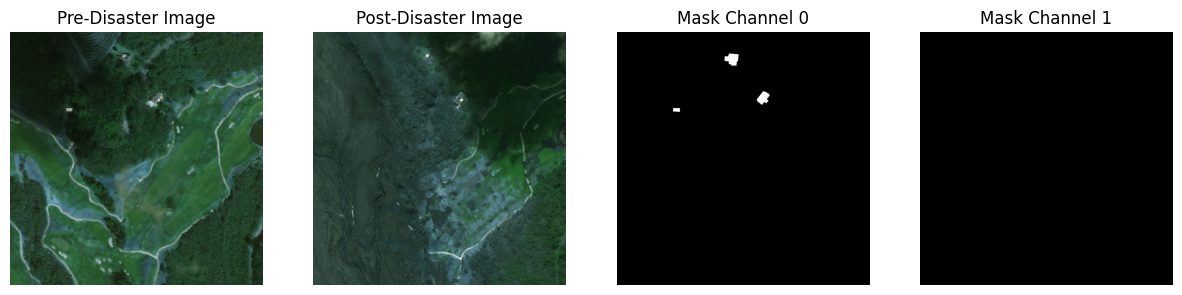

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


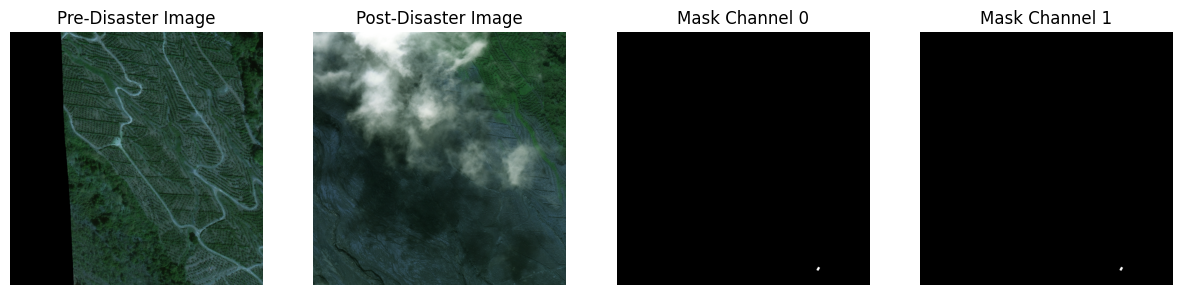

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


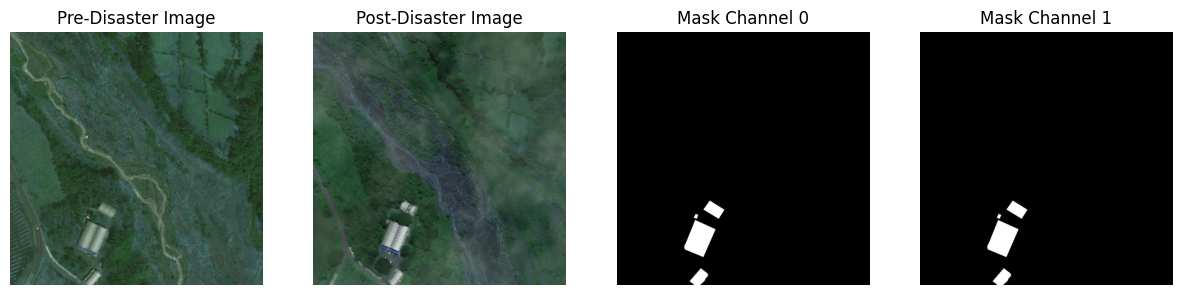

In [55]:
import matplotlib.pyplot as plt

# After loading processed_data
for i in range(3):  # Visualize first 3 samples
    sample = processed_data[i]
    img = sample['img'].numpy().transpose(1, 2, 0)  # Shape: (H, W, 6)
    msk = sample['msk'].numpy().transpose(1, 2, 0)  # Shape: (H, W, C)

    # Separate pre- and post-disaster images
    pre_img = img[:, :, :3]   # First 3 channels
    post_img = img[:, :, 3:]  # Last 3 channels

    # De-normalize images for display
    pre_img_display = (pre_img + 1) * 127.5 / 255
    post_img_display = (post_img + 1) * 127.5 / 255

    # Display the images and masks
    plt.figure(figsize=(15, 5))

    # Display pre-disaster image
    plt.subplot(1, 4, 1)
    plt.imshow(pre_img_display)
    plt.title('Pre-Disaster Image')
    plt.axis('off')

    # Display post-disaster image
    plt.subplot(1, 4, 2)
    plt.imshow(post_img_display)
    plt.title('Post-Disaster Image')
    plt.axis('off')

    # Display the first mask channel (e.g., building presence)
    plt.subplot(1, 4, 3)
    plt.imshow(msk[..., 0], cmap='gray')
    plt.title('Mask Channel 0')
    plt.axis('off')

    # Display the second mask channel (e.g., damage level 1)
    plt.subplot(1, 4, 4)
    plt.imshow(msk[..., 1], cmap='gray')
    plt.title('Mask Channel 1')
    plt.axis('off')

    plt.show()


In [56]:
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
test_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in test_results.items():
    print(f"{channel}: {f1_score:.4f}")


test_channel_0_F1: 0.8633
test_channel_1_F1: 0.8283
test_channel_2_F1: 0.3694
test_channel_3_F1: 0.6474
test_channel_4_F1: 0.7139


# analysis of arkansas

In [19]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Arkansas"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Arkansas_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
california_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in california_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8762
test_channel_1_F1: 0.8669
test_channel_2_F1: 0.0157
test_channel_3_F1: 0.4314
test_channel_4_F1: 0.0370


# analysis of california

In [20]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\California"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\California_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
california_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in california_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8603
test_channel_1_F1: 0.8548
test_channel_2_F1: 0.0395
test_channel_3_F1: 0.0147
test_channel_4_F1: 0.8210


# analysis of mexico

In [21]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Mexico"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Mexico_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
mexico_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in mexico_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8371
test_channel_1_F1: 0.8316
test_channel_2_F1: 0.0000
test_channel_3_F1: 0.0284
test_channel_4_F1: 0.0000


# analysis of florida

In [22]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Florida"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Florida_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
florida_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in florida_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8594
test_channel_1_F1: 0.7116
test_channel_2_F1: 0.3812
test_channel_3_F1: 0.4145
test_channel_4_F1: 0.4271


# analysis of hawai

In [25]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Hawaii"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Hawaii_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8142
test_channel_1_F1: 0.7084
test_channel_2_F1: 0.1195
test_channel_3_F1: 0.0000
test_channel_4_F1: 0.1861


# analysis of Missouri

In [26]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Missouri"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Missouri_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.9027
test_channel_1_F1: 0.8373
test_channel_2_F1: 0.2303
test_channel_3_F1: 0.3232
test_channel_4_F1: 0.7358


# analysis of Nepal

In [27]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Nepal"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Nepal_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.7765
test_channel_1_F1: 0.6843
test_channel_2_F1: 0.1036
test_channel_3_F1: 0.2686
test_channel_4_F1: 0.0106


# analysis of oklahoma

In [28]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\oklahoma"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\oklahoma_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.9070
test_channel_1_F1: 0.8851
test_channel_2_F1: 0.5298
test_channel_3_F1: 0.3174
test_channel_4_F1: 0.7983


# analysis of portugal

In [29]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Portugal"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Portugal_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.7666
test_channel_1_F1: 0.6641
test_channel_2_F1: 0.0123
test_channel_3_F1: 0.0975
test_channel_4_F1: 0.2328


# analysis of south australia

In [30]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\South_australia"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\South_australia_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.6941
test_channel_1_F1: 0.6907
test_channel_2_F1: 0.0013
test_channel_3_F1: 0.0344
test_channel_4_F1: 0.5188


# analysis of south carolina

In [31]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\South_Carolina"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\South_Carolina_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
carolina_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in carolina_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8931
test_channel_1_F1: 0.8629
test_channel_2_F1: 0.0660
test_channel_3_F1: 0.6761
test_channel_4_F1: 0.1086


# analysis of indonesia

In [32]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Indonesia"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Indonesia_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
indonesia_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in indonesia_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8887
test_channel_1_F1: 0.8760
test_channel_2_F1: 0.0000
test_channel_3_F1: 0.0771
test_channel_4_F1: 0.7649


# analysis of texas

In [33]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Texas"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Texas_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8832
test_channel_1_F1: 0.8112
test_channel_2_F1: 0.2981
test_channel_3_F1: 0.7507
test_channel_4_F1: 0.0297


# analysis of locations not seen by the model

# 1. alabama
# 2. Guatemala
# 3. Sunda
# 4. ayiti

# Analysis of alabama

In [34]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Alabama"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Alabama_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.8090
test_channel_1_F1: 0.7523
test_channel_2_F1: 0.2152
test_channel_3_F1: 0.2539
test_channel_4_F1: 0.5500


# analysis of Guatemala

In [35]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Guatemala"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Guatemala_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.5163
test_channel_1_F1: 0.5783
test_channel_2_F1: 0.1158
test_channel_3_F1: 0.0000
test_channel_4_F1: 0.4264


# analysis if sunda

In [36]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\sunda"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\sunda_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.7101
test_channel_1_F1: 0.6434
test_channel_2_F1: 0.0000
test_channel_3_F1: 0.0000
test_channel_4_F1: 0.0000


# analysis of Ayiti

In [37]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Ayiti"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\location_test_data\\Ayiti_masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
texas_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in texas_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.7455
test_channel_1_F1: 0.3734
test_channel_2_F1: 0.5150
test_channel_3_F1: 0.1394
test_channel_4_F1: 0.3378


# analysing out-of-domain dataset (Ida-BD)

In [8]:
#creating test data loader
images_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\Ida-BD_dataset\\images"
masks_folder = "C:\\Users\\PC\\Desktop\\damage_assessement_data\\Ida-BD_dataset\\masks"
processed_data = process_images(images_folder, masks_folder)
dataloader = create_dataset(processed_data)
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
ida_bd_results = evaluate_model(model, dataloader, device='cuda')

# Print the F1 scores for each channel
for channel, f1_score in ida_bd_results.items():
    print(f"{channel}: {f1_score:.4f}")

test_channel_0_F1: 0.7654
test_channel_1_F1: 0.5873
test_channel_2_F1: 0.0150
test_channel_3_F1: 0.0039
test_channel_4_F1: 0.0620
